In [3]:
# Cell 1: Import và test dataset
import sys
import os
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)

import torch
from torchvision import transforms
from src.data.dataset import ChestXrayDataset

print("✅ Import successful!")

# Test dataset
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ChestXrayDataset(
    root_dir='../data/processed/train',
    transform=test_transform
)

print(f"\n✅ Dataset loaded!")
print(f"Total samples: {len(train_dataset)}")
print(f"Classes: {train_dataset.classes}")

# Test lấy 1 sample
image, label = train_dataset[0]
print(f"\n✅ Sample test:")
print(f"  Image shape: {image.shape}")
print(f"  Label: {label} ({train_dataset.classes[label]})")

print("\n📊 Class distribution:")
for cls, count in train_dataset.get_class_distribution().items():
    print(f"  {cls:15s}: {count:5d}")

✅ Import successful!
✅ Loaded 11546 images from ../data/processed/train

✅ Dataset loaded!
Total samples: 11546
Classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']

✅ Sample test:
  Image shape: torch.Size([3, 224, 224])
  Label: 0 (COVID-19)

📊 Class distribution:
  COVID-19       :   404
  Normal         :  4668
  Pneumonia      :  5984
  Tuberculosis   :   490


In [4]:
# Cell 2: Setup config
CONFIG = {
    'num_classes': 4,
    'batch_size': 32,
    'num_epochs': 10,  # Bắt đầu với 10 epochs để test
    'learning_rate': 0.001,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': '../data/processed',
    'checkpoint_dir': '../checkpoints'
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  num_classes: 4
  batch_size: 32
  num_epochs: 10
  learning_rate: 0.001
  device: cuda
  data_dir: ../data/processed
  checkpoint_dir: ../checkpoints


In [5]:
# Cell 3: Tạo DataLoaders
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Dùng stats từ preprocessing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4909, 0.4930, 0.4941],  # Từ normalization_stats.json
        std=[0.2407, 0.2408, 0.2414]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4909, 0.4930, 0.4941],
        std=[0.2407, 0.2408, 0.2414]
    )
])

# Tạo datasets
train_dataset = ChestXrayDataset(
    root_dir='../data/processed/train',
    transform=train_transform
)

val_dataset = ChestXrayDataset(
    root_dir='../data/processed/val',
    transform=val_transform
)

# Tạo dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True if CONFIG['device'] == 'cuda' else False
)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Val samples: {len(val_dataset)}")
print(f"✅ Train batches: {len(train_loader)}")
print(f"✅ Val batches: {len(val_loader)}")

✅ Loaded 11546 images from ../data/processed/train
✅ Loaded 2471 images from ../data/processed/val
✅ Train samples: 11546
✅ Val samples: 2471
✅ Train batches: 361
✅ Val batches: 78


In [6]:
# Cell 4: Khởi tạo model, loss, optimizer
from src.models.cnn import SimpleCNN

model = SimpleCNN(num_classes=CONFIG['num_classes'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

print(f"✅ Model: SimpleCNN")
print(f"✅ Device: {CONFIG['device']}")
print(f"✅ Criterion: CrossEntropyLoss")
print(f"✅ Optimizer: Adam (lr={CONFIG['learning_rate']})")

# Đếm parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"✅ Total parameters: {total_params:,}")

✅ Model: SimpleCNN
✅ Device: cuda
✅ Criterion: CrossEntropyLoss
✅ Optimizer: Adam (lr=0.001)
✅ Total parameters: 26,082,052


In [7]:
# Cell 5: Tạo Trainer và BẮT ĐẦU TRAINING
from src.training.trainer import Trainer

trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=CONFIG['device'],
    checkpoint_dir=CONFIG['checkpoint_dir']
)

print("🚀 Starting training...")
print("=" * 70)

# BẮT ĐẦU TRAINING
history = trainer.train(num_epochs=CONFIG['num_epochs'], save_best=True)

print("\n✅ Training completed!")

🚀 Starting training...
Training on cuda
Total epochs: 10

Epoch 1/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [01:01<00:00,  1.27it/s, loss=0.265, acc=90.1]



Train Loss: 1.2556 | Train Acc: 83.47%
Val Loss: 0.2652 | Val Acc: 90.13%
✅ Saved best model! (Val Acc: 90.13%)

Epoch 2/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:44<00:00,  1.76it/s, loss=0.251, acc=91.6]



Train Loss: 0.3482 | Train Acc: 88.18%
Val Loss: 0.2510 | Val Acc: 91.62%
✅ Saved best model! (Val Acc: 91.62%)

Epoch 3/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:26<00:00,  2.93it/s, loss=0.206, acc=92.5]



Train Loss: 0.3235 | Train Acc: 89.06%
Val Loss: 0.2064 | Val Acc: 92.47%
✅ Saved best model! (Val Acc: 92.47%)

Epoch 4/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:18<00:00,  4.28it/s, loss=0.23, acc=92.9]    



Train Loss: 0.3216 | Train Acc: 89.41%
Val Loss: 0.2297 | Val Acc: 92.88%
✅ Saved best model! (Val Acc: 92.88%)

Epoch 5/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:18<00:00,  4.28it/s, loss=0.186, acc=94.1]



Train Loss: 0.2971 | Train Acc: 90.20%
Val Loss: 0.1861 | Val Acc: 94.09%
✅ Saved best model! (Val Acc: 94.09%)

Epoch 6/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:19<00:00,  3.97it/s, loss=0.17, acc=94.5] 



Train Loss: 0.2822 | Train Acc: 90.50%
Val Loss: 0.1696 | Val Acc: 94.46%
✅ Saved best model! (Val Acc: 94.46%)

Epoch 7/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:18<00:00,  4.30it/s, loss=0.177, acc=94.7]   



Train Loss: 0.2766 | Train Acc: 90.59%
Val Loss: 0.1765 | Val Acc: 94.74%
✅ Saved best model! (Val Acc: 94.74%)

Epoch 8/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:17<00:00,  4.50it/s, loss=0.189, acc=93.8]



Train Loss: 0.2717 | Train Acc: 90.70%
Val Loss: 0.1886 | Val Acc: 93.77%

Epoch 9/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:17<00:00,  4.45it/s, loss=0.155, acc=94.9]



Train Loss: 0.2601 | Train Acc: 91.24%
Val Loss: 0.1554 | Val Acc: 94.86%
✅ Saved best model! (Val Acc: 94.86%)

Epoch 10/10
------------------------------------------------------------


Validation: 100%|██████████| 78/78 [00:17<00:00,  4.36it/s, loss=0.146, acc=95.1]



Train Loss: 0.2345 | Train Acc: 91.95%
Val Loss: 0.1465 | Val Acc: 95.10%
✅ Saved best model! (Val Acc: 95.10%)

Training completed!
Best validation accuracy: 95.10%

✅ Training completed!


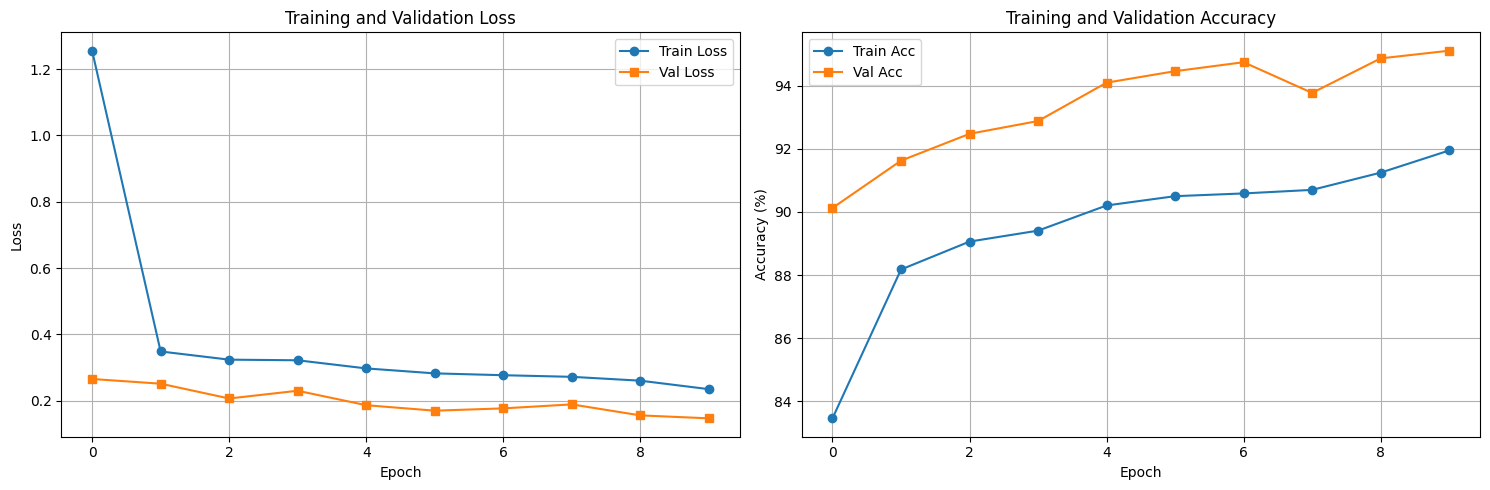

✅ Plot saved to: results/figures/cnn_training_history.png


In [8]:
# Cell 6: Visualize kết quả
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()

# Save figure
os.makedirs('../results/figures', exist_ok=True)
plt.savefig('../results/figures/cnn_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Plot saved to: results/figures/cnn_training_history.png")